# 第七组SIFT 实现

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline

In [2]:
original  = cv2.imread('4.2.03.tiff',0)
original .shape

(512, 512)

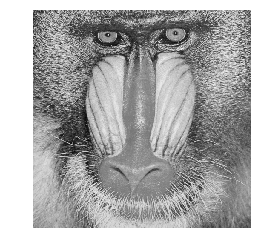

In [3]:
plt.imshow(original ,cmap = 'gray')
plt.axis("off")
plt.show()

In [4]:
# SIFT Parameters
threshold = 3
s = 3
k = 2 ** (1.0 / s)

kvec1 = np.array([1.3, 1.6, 1.6 * k, 1.6 * (k ** 2), 1.6 * (k ** 3), 1.6 * (k ** 4)])
kvec2 = np.array([1.6 * (k ** 2), 1.6 * (k ** 3), 1.6 * (k ** 4), 1.6 * (k ** 5), 1.6 * (k ** 6), 1.6 * (k ** 7)])
kvec3 = np.array([1.6 * (k ** 5), 1.6 * (k ** 6), 1.6 * (k ** 7), 1.6 * (k ** 8), 1.6 * (k ** 9), 1.6 * (k ** 10)])
kvec4 = np.array([1.6 * (k ** 8), 1.6 * (k ** 9), 1.6 * (k ** 10), 1.6 * (k ** 11), 1.6 * (k ** 12), 1.6 * (k ** 13)])
kvectotal = np.array([1.6, 1.6 * k, 1.6 * (k ** 2), 1.6 * (k ** 3), 1.6 * (k ** 4), 1.6 * (k ** 5), 1.6 * (k ** 6), 1.6 * (k ** 7), 1.6 * (k ** 8), 1.6 * (k ** 9), 1.6 * (k ** 10), 1.6 * (k ** 11)])

#降采样
x,y = original.shape
doubled = cv2.resize(original,(x*2,y*2), interpolation=cv2.INTER_LINEAR )  
normal = cv2.resize(doubled,(x,y), interpolation=cv2.INTER_LINEAR )
halved = cv2.resize(normal,(x//2,y//2), interpolation=cv2.INTER_LINEAR )
quartered = cv2.resize(halved,(x//4,y//4), interpolation=cv2.INTER_LINEAR )


# 创建高斯金字塔
pyrlvl1 = np.zeros((doubled.shape[0], doubled.shape[1], 6))
pyrlvl2 = np.zeros((normal.shape[0], normal.shape[1], 6))
pyrlvl3 = np.zeros((halved.shape[0], halved.shape[1], 6))
pyrlvl4 = np.zeros((quartered.shape[0], quartered.shape[1], 6))

#高斯金字塔赋值
for i in range(0, 6):
    pyrlvl1[:,:,i] = cv2.GaussianBlur(doubled,(5,5) ,kvec1[i])   
    pyrlvl2[:,:,i] = cv2.GaussianBlur(normal,(5,5) ,kvec2[i])   
    pyrlvl3[:,:,i] = cv2.GaussianBlur(halved,(5,5) ,kvec3[i])   
    pyrlvl4[:,:,i] = cv2.GaussianBlur(quartered,(5,5) ,kvec4[i])   

#创建DoG
diffpyrlvl1 = np.zeros((doubled.shape[0], doubled.shape[1], 5))
diffpyrlvl2 = np.zeros((normal.shape[0], normal.shape[1], 5))
diffpyrlvl3 = np.zeros((halved.shape[0], halved.shape[1], 5))
diffpyrlvl4 = np.zeros((quartered.shape[0], quartered.shape[1], 5))

#DoG赋值
for i in range(0, 5):
    diffpyrlvl1[:,:,i] = pyrlvl1[:,:,i+1] - pyrlvl1[:,:,i]
    diffpyrlvl2[:,:,i] = pyrlvl2[:,:,i+1] - pyrlvl2[:,:,i]
    diffpyrlvl3[:,:,i] = pyrlvl3[:,:,i+1] - pyrlvl3[:,:,i]
    diffpyrlvl4[:,:,i] = pyrlvl4[:,:,i+1] - pyrlvl4[:,:,i]


    
extrpyrlvl1 = np.zeros((doubled.shape[0], doubled.shape[1], 3))
extrpyrlvl2 = np.zeros((normal.shape[0], normal.shape[1], 3))
extrpyrlvl3 = np.zeros((halved.shape[0], halved.shape[1], 3))
extrpyrlvl4 = np.zeros((quartered.shape[0], quartered.shape[1], 3))

print("Starting extrema detection...")
print("First octave")

threshold = np.mean(diffpyrlvl1)

for i in range(1, 4):
    for j in range(80, doubled.shape[0] - 80):
        for k in range(80, doubled.shape[1] - 80):
            if np.absolute(diffpyrlvl1[j, k, i]) < threshold:
                continue    

            maxbool = (diffpyrlvl1[j, k, i] > 0)
            minbool = (diffpyrlvl1[j, k, i] < 0)

            for di in range(-1, 2):
                for dj in range(-1, 2):
                    for dk in range(-1, 2):
                        if di == 0 and dj == 0 and dk == 0:
                            continue
                        maxbool = maxbool and (diffpyrlvl1[j, k, i] > diffpyrlvl1[j + dj, k + dk, i + di])
                        minbool = minbool and (diffpyrlvl1[j, k, i] < diffpyrlvl1[j + dj, k + dk, i + di])
                        if not maxbool and not minbool:
                            break

                    if not maxbool and not minbool:
                        break

                if not maxbool and not minbool:
                    break

            if maxbool or minbool:
                dx = (diffpyrlvl1[j, k+1, i] - diffpyrlvl1[j, k-1, i]) * 0.5 / 255
                dy = (diffpyrlvl1[j+1, k, i] - diffpyrlvl1[j-1, k, i]) * 0.5 / 255
                ds = (diffpyrlvl1[j, k, i+1] - diffpyrlvl1[j, k, i-1]) * 0.5 / 255
                dxx = (diffpyrlvl1[j, k+1, i] + diffpyrlvl1[j, k-1, i] - 2 * diffpyrlvl1[j, k, i]) * 1.0 / 255        
                dyy = (diffpyrlvl1[j+1, k, i] + diffpyrlvl1[j-1, k, i] - 2 * diffpyrlvl1[j, k, i]) * 1.0 / 255          
                dss = (diffpyrlvl1[j, k, i+1] + diffpyrlvl1[j, k, i-1] - 2 * diffpyrlvl1[j, k, i]) * 1.0 / 255
                dxy = (diffpyrlvl1[j+1, k+1, i] - diffpyrlvl1[j+1, k-1, i] - diffpyrlvl1[j-1, k+1, i] + diffpyrlvl1[j-1, k-1, i]) * 0.25 / 255 
                dxs = (diffpyrlvl1[j, k+1, i+1] - diffpyrlvl1[j, k-1, i+1] - diffpyrlvl1[j, k+1, i-1] + diffpyrlvl1[j, k-1, i-1]) * 0.25 / 255 
                dys = (diffpyrlvl1[j+1, k, i+1] - diffpyrlvl1[j-1, k, i+1] - diffpyrlvl1[j+1, k, i-1] + diffpyrlvl1[j-1, k, i-1]) * 0.25 / 255  

                dD = np.matrix([[dx], [dy], [ds]])
                H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
                x_hat = np.linalg.lstsq(H, dD)[0]
                D_x_hat = diffpyrlvl1[j, k, i] + 0.5 * np.dot(dD.transpose(), x_hat)

                r = 10.0
                if ((((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2))) and (np.absolute(x_hat[0]) < 0.5) and (np.absolute(x_hat[1]) < 0.5) and (np.absolute(x_hat[2]) < 0.5) and (np.absolute(D_x_hat) > 0.03):
                    extrpyrlvl1[j, k, i - 1] = 1

print("Second octave")

threshold = np.mean(diffpyrlvl2)

for i in range(1, 4):
    for j in range(40, normal.shape[0] - 40):
        for k in range(40, normal.shape[1] - 40):
            if np.absolute(diffpyrlvl2[j, k, i]) < threshold:
                continue   

            maxbool = (diffpyrlvl2[j, k, i] > 0)
            minbool = (diffpyrlvl2[j, k, i] < 0)

            for di in range(-1, 2):
                for dj in range(-1, 2):
                    for dk in range(-1, 2):
                        if di == 0 and dj == 0 and dk == 0:
                            continue
                        maxbool = maxbool and (diffpyrlvl2[j, k, i] > diffpyrlvl2[j + dj, k + dk, i + di])
                        minbool = minbool and (diffpyrlvl2[j, k, i] < diffpyrlvl2[j + dj, k + dk, i + di])
                        if not maxbool and not minbool:
                            break

                    if not maxbool and not minbool:
                        break

                if not maxbool and not minbool:
                    break

            if maxbool or minbool:
                dx = (diffpyrlvl2[j, k+1, i] - diffpyrlvl2[j, k-1, i]) * 0.5 / 255
                dy = (diffpyrlvl2[j+1, k, i] - diffpyrlvl2[j-1, k, i]) * 0.5 / 255
                ds = (diffpyrlvl2[j, k, i+1] - diffpyrlvl2[j, k, i-1]) * 0.5 / 255
                dxx = (diffpyrlvl2[j, k+1, i] + diffpyrlvl2[j, k-1, i] - 2 * diffpyrlvl2[j, k, i]) * 1.0 / 255        
                dyy = (diffpyrlvl2[j+1, k, i] + diffpyrlvl2[j-1, k, i] - 2 * diffpyrlvl2[j, k, i]) * 1.0 / 255          
                dss = (diffpyrlvl2[j, k, i+1] + diffpyrlvl2[j, k, i-1] - 2 * diffpyrlvl2[j, k, i]) * 1.0 / 255
                dxy = (diffpyrlvl2[j+1, k+1, i] - diffpyrlvl2[j+1, k-1, i] - diffpyrlvl2[j-1, k+1, i] + diffpyrlvl2[j-1, k-1, i]) * 0.25 / 255 
                dxs = (diffpyrlvl2[j, k+1, i+1] - diffpyrlvl2[j, k-1, i+1] - diffpyrlvl2[j, k+1, i-1] + diffpyrlvl2[j, k-1, i-1]) * 0.25 / 255 
                dys = (diffpyrlvl2[j+1, k, i+1] - diffpyrlvl2[j-1, k, i+1] - diffpyrlvl2[j+1, k, i-1] + diffpyrlvl2[j-1, k, i-1]) * 0.25 / 255  

                dD = np.matrix([[dx], [dy], [ds]])
                H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
                x_hat = np.linalg.lstsq(H, dD)[0]
                D_x_hat = diffpyrlvl2[j, k, i] + 0.5 * np.dot(dD.transpose(), x_hat)

                r = 10.0
                if (((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2)) and np.absolute(x_hat[0]) < 0.5 and np.absolute(x_hat[1]) < 0.5 and np.absolute(x_hat[2]) < 0.5 and np.absolute(D_x_hat) > 0.03:
                    extrpyrlvl2[j, k, i - 1] = 1

print("Third octave")

threshold = np.mean(diffpyrlvl3)

for i in range(1, 4):
    for j in range(20, halved.shape[0] - 20):
        for k in range(20, halved.shape[1] - 20):
            if np.absolute(diffpyrlvl3[j, k, i]) < threshold:
                continue    

            maxbool = (diffpyrlvl3[j, k, i] > 0)
            minbool = (diffpyrlvl3[j, k, i] < 0)

            for di in range(-1, 2):
                for dj in range(-1, 2):
                    for dk in range(-1, 2):
                        if di == 0 and dj == 0 and dk == 0:
                            continue
                        maxbool = maxbool and (diffpyrlvl3[j, k, i] > diffpyrlvl3[j + dj, k + dk, i + di])
                        minbool = minbool and (diffpyrlvl3[j, k, i] < diffpyrlvl3[j + dj, k + dk, i + di])
                        if not maxbool and not minbool:
                            break

                    if not maxbool and not minbool:
                        break

                if not maxbool and not minbool:
                    break

            if maxbool or minbool:
                dx = (diffpyrlvl3[j, k+1, i] - diffpyrlvl3[j, k-1, i]) * 0.5 / 255
                dy = (diffpyrlvl3[j+1, k, i] - diffpyrlvl3[j-1, k, i]) * 0.5 / 255
                ds = (diffpyrlvl3[j, k, i+1] - diffpyrlvl3[j, k, i-1]) * 0.5 / 255
                dxx = (diffpyrlvl3[j, k+1, i] + diffpyrlvl3[j, k-1, i] - 2 * diffpyrlvl3[j, k, i]) * 1.0 / 255        
                dyy = (diffpyrlvl3[j+1, k, i] + diffpyrlvl3[j-1, k, i] - 2 * diffpyrlvl3[j, k, i]) * 1.0 / 255          
                dss = (diffpyrlvl3[j, k, i+1] + diffpyrlvl3[j, k, i-1] - 2 * diffpyrlvl3[j, k, i]) * 1.0 / 255
                dxy = (diffpyrlvl3[j+1, k+1, i] - diffpyrlvl3[j+1, k-1, i] - diffpyrlvl3[j-1, k+1, i] + diffpyrlvl3[j-1, k-1, i]) * 0.25 / 255 
                dxs = (diffpyrlvl3[j, k+1, i+1] - diffpyrlvl3[j, k-1, i+1] - diffpyrlvl3[j, k+1, i-1] + diffpyrlvl3[j, k-1, i-1]) * 0.25 / 255 
                dys = (diffpyrlvl3[j+1, k, i+1] - diffpyrlvl3[j-1, k, i+1] - diffpyrlvl3[j+1, k, i-1] + diffpyrlvl3[j-1, k, i-1]) * 0.25 / 255  

                dD = np.matrix([[dx], [dy], [ds]])
                H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
                x_hat = np.linalg.lstsq(H, dD)[0]
                D_x_hat = diffpyrlvl3[j, k, i] + 0.5 * np.dot(dD.transpose(), x_hat)

                r = 10.0
                if (((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2)) and np.absolute(x_hat[0]) < 0.5 and np.absolute(x_hat[1]) < 0.5 and np.absolute(x_hat[2]) < 0.5 and np.absolute(D_x_hat) > 0.03:
                    extrpyrlvl3[j, k, i - 1] = 1


print("Fourth octave")

threshold = np.mean(diffpyrlvl4)

for i in range(1, 4):
    for j in range(10, quartered.shape[0] - 10):
        for k in range(10, quartered.shape[1] - 10):
            if np.absolute(diffpyrlvl4[j, k, i]) < threshold:
                continue

            maxbool = (diffpyrlvl4[j, k, i] > 0)
            minbool = (diffpyrlvl4[j, k, i] < 0)

            for di in range(-1, 2):
                for dj in range(-1, 2):
                    for dk in range(-1, 2):
                        if di == 0 and dj == 0 and dk == 0:
                            continue
                        maxbool = maxbool and (diffpyrlvl4[j, k, i] > diffpyrlvl4[j + dj, k + dk, i + di])
                        minbool = minbool and (diffpyrlvl4[j, k, i] < diffpyrlvl4[j + dj, k + dk, i + di])
                        if not maxbool and not minbool:
                            break

                    if not maxbool and not minbool:
                        break

                if not maxbool and not minbool:
                    break

            if maxbool or minbool:
                dx = (diffpyrlvl4[j, k+1, i] - diffpyrlvl4[j, k-1, i]) * 0.5 / 255
                dy = (diffpyrlvl4[j+1, k, i] - diffpyrlvl4[j-1, k, i]) * 0.5 / 255
                ds = (diffpyrlvl4[j, k, i+1] - diffpyrlvl4[j, k, i-1]) * 0.5 / 255
                dxx = (diffpyrlvl4[j, k+1, i] + diffpyrlvl4[j, k-1, i] - 2 * diffpyrlvl4[j, k, i]) * 1.0 / 255        
                dyy = (diffpyrlvl4[j+1, k, i] + diffpyrlvl4[j-1, k, i] - 2 * diffpyrlvl4[j, k, i]) * 1.0 / 255          
                dss = (diffpyrlvl4[j, k, i+1] + diffpyrlvl4[j, k, i-1] - 2 * diffpyrlvl4[j, k, i]) * 1.0 / 255
                dxy = (diffpyrlvl4[j+1, k+1, i] - diffpyrlvl4[j+1, k-1, i] - diffpyrlvl4[j-1, k+1, i] + diffpyrlvl4[j-1, k-1, i]) * 0.25 / 255 
                dxs = (diffpyrlvl4[j, k+1, i+1] - diffpyrlvl4[j, k-1, i+1] - diffpyrlvl4[j, k+1, i-1] + diffpyrlvl4[j, k-1, i-1]) * 0.25 / 255 
                dys = (diffpyrlvl4[j+1, k, i+1] - diffpyrlvl4[j-1, k, i+1] - diffpyrlvl4[j+1, k, i-1] + diffpyrlvl4[j-1, k, i-1]) * 0.25 / 255  

                dD = np.matrix([[dx], [dy], [ds]])
                H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
                x_hat = np.linalg.lstsq(H, dD)[0]
                D_x_hat = diffpyrlvl4[j, k, i] + 0.5 * np.dot(dD.transpose(), x_hat)

                r = 10.0
                if (((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2)) and np.absolute(x_hat[0]) < 0.5 and np.absolute(x_hat[1]) < 0.5 and np.absolute(x_hat[2]) < 0.5 and np.absolute(D_x_hat) > 0.03:
                    extrpyrlvl4[j, k, i - 1] = 1
                
                
                
print ("Number of extrema in first octave: %d" % np.sum(extrpyrlvl1))
print ("Number of extrema in second octave: %d" % np.sum(extrpyrlvl2))
print ("Number of extrema in third octave: %d" % np.sum(extrpyrlvl3))
print ("Number of extrema in fourth octave: %d" % np.sum(extrpyrlvl4))
    

Starting extrema detection...
First octave


C:\Users\kami\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Second octave


C:\Users\kami\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Third octave


C:\Users\kami\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Fourth octave


C:\Users\kami\Anaconda3\lib\site-packages\ipykernel_launcher.py:244: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Number of extrema in first octave: 15575
Number of extrema in second octave: 5139
Number of extrema in third octave: 1952
Number of extrema in fourth octave: 148


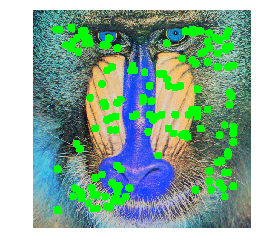

In [5]:
extrpyrlvl4_copy = extrpyrlvl4.copy()

__extrpyrlvl = cv2.resize(extrpyrlvl4[:,:,0],(extrpyrlvl4.shape[0]*4,extrpyrlvl4.shape[0]*4), interpolation=cv2.INTER_LINEAR ) 

im  = cv2.imread('4.2.03.tiff')

for i in range(512):
    for j in range(512):
        if __extrpyrlvl[i,j] > 0:
            cv2.circle(im, (i,j), 5, (0,255,0),1)
            
plt.imshow(im)
plt.axis("off")
plt.show()
          

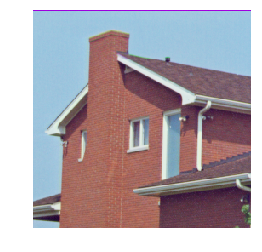

In [6]:
img = cv2.imread('.\\data\\4.1.05.tiff')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

# SIFT调用库函数实现

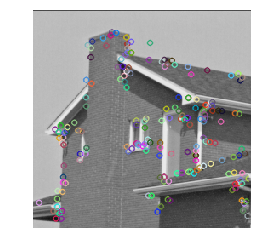

In [7]:
img = cv2.imread('.\\data\\4.1.05.tiff')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
img=cv2.drawKeypoints(gray,kp,img)
plt.imshow(img)
plt.axis("off")
plt.show()

# SURF调用库函数实现

44


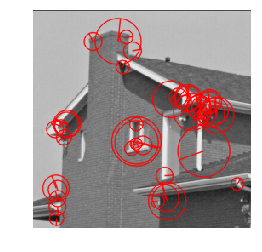

(<matplotlib.image.AxesImage at 0x15a347dca20>,
 (-0.5, 255.5, 255.5, -0.5),
 None)

In [8]:

img = cv2.imread('.\\data\\4.1.05.tiff')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

surf = cv2.xfeatures2d.SURF_create(3000)
kp, des = surf.detectAndCompute(gray,None)
print( len(kp) )

img2 = cv2.drawKeypoints(gray,kp,None,(255,0,0),4)
plt.imshow(img2),plt.axis("off"),plt.show()